In [1]:
# 2018-09-20
# A. Pendleton
# Link gene models from version 3 (500kb introns) to version 2 (100 kb introns)

In [71]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    #print(cmd)
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
def write_pbs_file(wkDir,cmdsFile,jobName, mem, jobCount):
    #write PBS file
    if '/scripts/' in wkDir:
        wkDir = wkDir.replace('/scripts/','')
    pbsFile = open(cmdsFile.replace('.cmds','.pbs'),'w')
    print('Writing pbs file: %s'% pbsFile)
    pbsFile.write('#!/bin/bash\n')
    pbsFile.write('#PBS -S /bin/bash\n')
    pbsFile.write('#PBS -V\n')
    pbsFile.write('#PBS -M ampend@med.umich.edu\n')
    pbsFile.write('#PBS -j oe\n')
    pbsFile.write('#PBS -N %s\n' % jobName)
    pbsFile.write('#PBS -o %s\n' % (wkDir + 'logs/'))
    pbsFile.write('#PBS -l pmem=%iG\n' % mem)
    pbsFile.write('#PBS -l nodes=1:ppn=1,qos=flux,walltime=100:00:00\n')
    pbsFile.write('##PBS -A medbsm_flux\n')
    pbsFile.write('##PBS -q flux\n')
    pbsFile.write('#PBS -A jmkidd_fluxod\n')
    pbsFile.write('#PBS -q fluxod\n')
    pbsFile.write('#PBS -t 1-%s\n' % jobCount)
    pbsFile.write('cd %s\n' % (wkDir))
    pbsFile.write('/home/ampend/links/kidd-lab/jmkidd-projects/scripts/perlUtils/run-by-id-log.pl %s %sBLAT_commands.logs $PBS_ARRAYID' % (cmdsFile,cmdsFile.replace('/scripts/','/logs/')))
    pbsFile.close()

# Define inputs

In [4]:
v2Dir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/'
v2CDSFile = v2Dir + 'TotalSet_NoRMSingleExons_AllMultiExons_cds.fa'

v3Dir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/'
v3CDSFile = v3Dir + 'TotalSet_NoRMSingleExons_AllMultiExons_cds.fa'


# Set working directory for linking v2 to v3

In [6]:
wkDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/LinkToVersion2Models/'

# BLAT commands

In [8]:
# fatotwobit version2 to make database
cmd = 'faToTwoBit %s %s.2bit' % (v2CDSFile,v2CDSFile)
print(cmd)
#runCMD(cmd)

#BLAT
blatFile = wkDir + 'BLAT_version3_against_version2.psl' #desired output file
cmd = 'blat %s.2bit %s %s' % (v2CDSFile,v3CDSFile,blatFile)
print(cmd)
#runCMD(cmd)


faToTwoBit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa.2bit
blat /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa.2bit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/LinkToVersion2Models/BLAT_version3_against_version2.psl


# Create list of all version 3 (500kb intron) genes

In [37]:
v3Genes = []

for line in open(v3CDSFile,'r'):
    if '>' not in line: #only want fasta headers which have the gene IDs in them
        continue
    line = line.rstrip()
    line = line.replace('>','') #remove > symbol
    
    v3Genes.append(line)
print('%i v3 genes (500kb introns) added to dictionary' % len(v3Genes))

45443 v3 genes (500kb introns) added to dictionary


# Parse BLAT file to link the gene models

In [23]:
linkDict = {}

for line in open(blatFile,'r'):
    line = line.rstrip().split()
    #skip header lines
    if 'psLayout' in line or len(line) == 0 or 'match' in line[0] or '-' in line[0]:
        continue
    
    hitScore = int(line[0])
    strand = line[8]
    
    v3Gene = line[9] # QUERY
    v3Length,v3Start,v3End = int(line[10]),int(line[11]),int(line[12])

    v2Gene = line[13] # DATABASE GENE
    v2Length,v2Start,v2End = int(line[14]),int(line[15]),int(line[16])
    
    ####FILTRATIONS
    #BLOCK COUNT
    blockCount = int(line[17])
    if blockCount != 1:
        continue
    
    #Must be same length
    if v3Length != v2Length:
        continue
    
    #Score must equal length of both genes
    if hitScore != v3Length:
        continue
    
    linkDict[v3Gene] = v2Gene
    #print(line) 
    #break

print('%i v3 genes (500kb introns) could be linked to v2 genes' % len(linkDict.keys()))

22209 v3 genes (500kb introns) could be linked to v2 genes


# Determine which v3 genes do not have a match in v2

In [40]:
linkFile = open(wkDir + 'Link_Version3Genes_Version2Genes.txt','w')
hasPairing, noPairing = 0, 0


for gene in v3Genes:
    if gene not in linkDict.keys():
        linkFile.write('%s\tNA\n' % (gene))
        noPairing+=1
    else:
        linkFile.write('%s\t%s\n' % (gene,linkDict[gene]) )
        hasPairing+=1
linkFile.close()

print('%i/%i genes have a match in version 2' % (hasPairing,len(v3Genes)))
print('%i/%i genes DO NOT have a match in version 2' % (noPairing,len(v3Genes)))
    

22209/45443 genes have a match in version 2
23234/45443 genes DO NOT have a match in version 2


# BLAT all v all  ---- Pseudogene search

In [87]:
#Make directory for these steps
psDir = '%s../Pseudogene_Search/' % v3Dir
cmd = 'mkdir -p %s' % psDir
print(cmd)
runCMD(cmd)

#Generate two-bit file of the v3 cds fasta
cmd = 'faToTwoBit %s %s.2bit' % (v3CDSFile,v3CDSFile)
print(cmd)
runCMD(cmd)

#BLAT v3 2bit versus v3 CDS
blatOutFile = '%sBLAT_V3CDS_v_V3CDS.psl'  % psDir
cmd = 'blat %s.2bit %s %s' % (v3CDSFile,v3CDSFile,blatOutFile)
print(cmd)
#runCMD(cmd)

print('BLAT Done!!!!')

mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/../Pseudogene_Search/
faToTwoBit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa.2bit
blat /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa.2bit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_int

### Generate EXON and INTRON ONLY bed files

In [200]:
nonRedundant_v3Bed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons.bed'
exons_nonRedv3_bed = open(nonRedundant_v3Bed.replace('.bed','.exons.bed'),'w')
introns_nonRedv3_bed = open(nonRedundant_v3Bed.replace('.bed','.introns.bed'),'w')

for line in open(nonRedundant_v3Bed,'r'):
    if 'track' in line:
        continue
    line=line.rstrip().split('\t')
    chrom,start,end,strand = line[0],int(line[1]),int(line[2]),line[5]
    geneID = line[3].replace('ID=','').split(';')[0]
    
    exonCount = int(line[9])# == blockCount
    exonLengths = line[10].split(',')
    exonStarts = line[11].split(',')
    blockOverallStart,blockOverallEnd = int(line[6]),int(line[7])
    
    #WRITE OUT THE EXONS
    exonStartList = []
    for i in range(0,exonCount):
        #Exon coordinates
        exS = start + int(exonStarts[i])
        exE = start + int(exonStarts[i]) + int(exonLengths[i])
        exons_nonRedv3_bed.write('%s\t%i\t%i\t%s_exon%i\n' % (chrom,exS,exE,geneID,(i+1)))
        exonStartList.append(exS)
        
        #Intron coordinates
        if i == 0: #can only calculate once we're at exon 1 or more
            continue
        inS,inE = int(exonStartList[i-1])+1,int(exonStartList[i])-1
        introns_nonRedv3_bed.write('%s\t%i\t%i\t%s_intron%i\n' % (chrom,inS,inE,geneID,(i+1)))

    
exons_nonRedv3_bed.close()
introns_nonRedv3_bed.close()


### Read BED file to find number of exons for each gene model

In [276]:
nonRedundant_v3Bed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons.bed'
exonDict = {}

for LINE in open(nonRedundant_v3Bed, 'r'):
    line=LINE.rstrip().split()
    if 'track' in line[0]: #skip header
        continue
    #Read in information on gene
    geneID = line[3].replace('ID=','').split(';')[0]
    shortID = line[3].split(';')[1]
    chrom,start,end,strand,info = line[0],int(line[1]),int(line[2]),line[5],line
    
    exonCount = int(line[9])
    exonLengths = line[10]
    #If geneID not already in dictionary, then add
    if geneID not in exonDict.keys():
        exonDict[geneID] = {}
        exonDict[geneID]['exonCount'] = exonCount
        exonDict[geneID]['exonLength'] = exonLengths
        exonDict[geneID]['chrom'] = chrom
        exonDict[geneID]['start'] = start
        exonDict[geneID]['end'] = end
        exonDict[geneID]['strand'] = strand
        exonDict[geneID]['info'] = info
        exonDict[geneID]['perfectHits'] = []
print('%i genes added to dictionary' % len(exonDict.keys()))

v3_pepFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep'

missingFromBed,count = [], 0
for line in open(v3_pepFile,'r'):
    if '>' not in line:
        continue
    line = line.rstrip().split()
    geneID = line[0].replace('>','')
    status = line[3].split(':')[1]
    if geneID in exonDict.keys():
        exonDict[geneID]['status'] = status
        count+=1
print('Added status of %i genes' % count)
    

45443 genes added to dictionary
Added status of 45443 genes


### Intersect CDS bed with CDS bed (reciprocal) to find intersecting gene models

In [293]:
exons_nonRedv3_bed = nonRedundant_v3Bed.replace('.bed','.exons.bed')
exonIntersectFile = psDir + 'Intersect_Version3_ExonsVExons.txt'
print(exonIntersectFile)

cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (exons_nonRedv3_bed,exons_nonRedv3_bed,exonIntersectFile)
print(cmd)
#runCMD(cmd)

SKIP_THESE_GENE_MODELS = []
SKIP_THESE_GENE_MODELS2 = []

for line in open(exonIntersectFile,'r'):
    line=line.rstrip().split('\t')
    gene1,gene2 = line[3].split('_exon')[0],line[7].split('_exon')[0]
    length_gene1, length_gene2 = int(line[2])-int(line[1]), int(line[6])-int(line[5])
    
    if gene1 == gene2: #Skip self-self hits
        continue
    if gene1 not in exonDict.keys(): #Only want the gene models 
        print('ERROR: Why is this gene not in dictionary?')
        continue

    if 'Gene.315437::chr4.g12627.i1::g.315437::m.315437' in gene1:
        print(line)
        propOfGene1Hit = int(line[-1])/length_gene1
        propOfGene2Hit = int(line[-1])/length_gene2
        print(propOfGene1Hit,propOfGene2Hit)
        print(exonDict[gene1]['status'])
        print(exonDict[gene2]['status'])
    #WE ONLY WANT SINGLE EXON GENE COMPARISONS
    gene1_exonCount = exonDict[gene1]['exonCount']
    gene2_exonCount = exonDict[gene2]['exonCount']
    if gene1_exonCount == 1 and gene2_exonCount == 1: #Only are interested in single exon gene models    
        #ONLY WANT HITS THAT ALIGN TO MOST OF THE SINGLE EXON MODELS (>90%)
        propOfGene1Hit = int(line[-1])/length_gene1
        propOfGene2Hit = int(line[-1])/length_gene2

        if propOfGene1Hit > .9:# and propOfGene2Hit > .9:
            
            #WANT TO SKIP MODELS THAT ARE SMALLER THAN THEIR OVERLAPPING HIT
            if length_gene1 <= length_gene2:
                
                #ADD GENE MODEL ID ONLY ONCE
                if gene1 not in SKIP_THESE_GENE_MODELS and gene2 not in SKIP_THESE_GENE_MODELS:
                    SKIP_THESE_GENE_MODELS.append(gene1)
        
        if propOfGene1Hit > .9 and propOfGene2Hit > .9:
            
            #WANT TO SKIP MODELS THAT ARE SMALLER THAN THEIR OVERLAPPING HIT
            if length_gene1 <= length_gene2:
                
                #ADD GENE MODEL ID ONLY ONCE
                if gene1 not in SKIP_THESE_GENE_MODELS2 and gene2 not in SKIP_THESE_GENE_MODELS2:
                    SKIP_THESE_GENE_MODELS2.append(gene1)
print('%i single exon gene models have >95% overlap with another single exon gene and should be ignored' % len(SKIP_THESE_GENE_MODELS))
print('%i single exon gene models have RECIPROCAL >95% overlaps with another single exon gene and should be ignored' % len(SKIP_THESE_GENE_MODELS2))


/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/../Pseudogene_Search/Intersect_Version3_ExonsVExons.txt
bedtools intersect -wo -a /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons.exons.bed -b /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons.exons.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/../Pseudogene_Search/Intersect_Version3_ExonsVExons.txt
['chr4', '29719707', '29721387', 'Gene.315437::chr4.g12627.i1::g.315437::m.315437_exon1', 'chr4', '29717687', '29721404', 'Gene.312042::chr4.g12621.i1::g.312042::m.312042_exon1', '1680']
1.0 0.4519774011299435
5prime_pa

TypeError: not enough arguments for format string

In [272]:
count = 0

for gene in SKIP_THESE_GENE_MODELS:
    if gene not in SKIP_THESE_GENE_MODELS2:
        count +=1
        print('\n# ',gene)
        print(exonDict[gene])
        print('%s:%s-%s'%(exonDict[gene]['chrom'],exonDict[gene]['start'],exonDict[gene]['end']))
        
    if count >5:
        break


#  Gene.41096::chr10.g913.i1::g.41096::m.41096
{'status': 'complete', 'chrom': 'chr10', 'strand': '+', 'end': 1136730, 'exonLength': '2289', 'info': ['chr10', '1134441', '1136730', 'Gene.41096::chr10.g913.i1::g.41096::m.41096;chr10.g913;ORF', '0', '+', '1135622', '1135943', '0', '1', '2289', '0'], 'start': 1134441, 'exonCount': 1}
chr10:1134441-1136730

#  Gene.47792::chr10.g5090.i1::g.47792::m.47792
{'status': 'complete', 'chrom': 'chr10', 'strand': '-', 'end': 11575751, 'exonLength': '3192', 'info': ['chr10', '11572559', '11575751', 'Gene.47792::chr10.g5090.i1::g.47792::m.47792;chr10.g5090;ORF', '0', '-', '11574890', '11575730', '0', '1', '3192', '0'], 'start': 11572559, 'exonCount': 1}
chr10:11572559-11575751

#  Gene.38047::chr10.g5363.i1::g.38047::m.38047
{'status': '3prime_partial', 'chrom': 'chr10', 'strand': '+', 'end': 12185014, 'exonLength': '361', 'info': ['chr10', '12184653', '12185014', 'Gene.38047::chr10.g5363.i1::g.38047::m.38047;chr10.g5363;ORF', '0', '+', '12184680', 

### Parse BLAT file and see how many single exons have perfect hits to another gene model

In [281]:
allvall_blatFile = blatOutFile
GENE_MODELS_PERFECT_HITS_POSSIBLE_PSEUDOGENES = []

for line in open(allvall_blatFile,'r'):
    line = line.rstrip().split()
    #skip header lines
    if 'psLayout' in line or len(line) == 0 or 'match' in line[0] or '-' in line[0]:
        continue
    hitScore = int(line[0])
    strand = line[8]
    # QUERY GENE INFO
    queryGene = line[9] 
    queryLength,queryStart,queryEnd = int(line[10]),int(line[11]),int(line[12])
    # DATABASE GENE INFO
    dbGene = line[13] 
    dbLength,dbStart,dbEnd = int(line[14]),int(line[15]),int(line[16])
    blockCount = int(line[17])
    
    #__CALCULATIONS__#
    hitThreshold = 0.95 #>95% of length == strong hit
    propHit = hitScore/queryLength
    
    #__FILTRATIONS__#
    #Ignore any that are self hits
    if queryGene == dbGene:
        continue
    
    #Ignore any where the query is not a single exon gene
    if exonDict[queryGene]['exonCount'] != 1:
        continue

    #Score must equal length of both genes
    if propHit < hitThreshold:
        continue
    if queryGene in SKIP_THESE_GENE_MODELS or dbGene in SKIP_THESE_GENE_MODELS:
        continue
    
    #Add the other hitting gene to the dictionary
    exonDict[queryGene]['perfectHits'].append([dbGene,propHit])

    GENE_MODELS_PERFECT_HITS_POSSIBLE_PSEUDOGENES.append(queryGene)
    #break
print('%i gene models added to SKIP_THESE_GENE_MODELS3' % len(GENE_MODELS_PERFECT_HITS_POSSIBLE_PSEUDOGENES))   



6685 gene models added to SKIP_THESE_GENE_MODELS3


6685


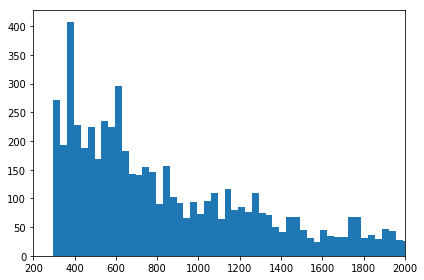

In [292]:
lengths_singleExonsPerfectHits = []

for gene in GENE_MODELS_PERFECT_HITS_POSSIBLE_PSEUDOGENES:
    length = exonDict[gene]['end']-exonDict[gene]['start']
    lengths_singleExonsPerfectHits.append(length)

print(len(lengths_singleExonsPerfectHits))

plt.hist(lengths_singleExonsPerfectHits,bins=1000)
plt.xlim(200,2000)
plt.tight_layout()
plt.show()

    #print(line)
    #print('#Query: ',queryGene)
    #print(exonDict[queryGene])
    ##print('%s:%s-%s'%(exonDict[queryGene]['chrom'],exonDict[queryGene]['start'],exonDict[queryGene]['end']))
    #print('\n#DB: ',dbGene)
    #print(exonDict[dbGene])
    #print('%s:%s-%s'%(exonDict[dbGene]['chrom'],exonDict[dbGene]['start'],exonDict[dbGene]['end']))


"""else:
    sameCoordStatus = determine_if_same_coords(exonDict,queryGene,dbGene)
    if sameCoordStatus == True:
        if dbGene in sameCoordPerfHits:
            continue
        else:
            sameCoordPerfHits.append(dbGene)
            continue
    if exonDict[queryGene]['chrom'] != exonDict[dbGene]['chrom']:
        continue

    print('Strong hit:',propHit)
    print('Coord status:',sameCoordStatus)
    print(str(line) + '\n') 
    print(exonDict[queryGene])
    print(exonDict[queryGene]['chrom'],exonDict[queryGene]['start'],exonDict[queryGene]['end'])
    print(exonDict[dbGene])
    print(exonDict[dbGene]['chrom'],exonDict[dbGene]['start'],exonDict[dbGene]['end'])
    break"""


# BLAST for BLAST2GO

### Define inputs

In [63]:
blastDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/'

cmd = 'mkdir -p %sinput/' % blastDir
print(cmd)
runCMD(cmd)

#Create directory for split fastas
fastaOutDir = blastDir + 'input/' + 'split_fastas/'
cmd = 'mkdir -p %s' % fastaOutDir
print(cmd)
runCMD(cmd)

#Out directory for BLAST results
blastpDir = blastDir + 'blastp_results/'
cmd = 'mkdir -p %s' % blastpDir
print(cmd)
runCMD(cmd)

#Scripts directory to write all the blastp commands to
scriptsDir = blastDir + 'scripts/'
cmd = 'mkdir -p %s' % scriptsDir
print(cmd)
runCMD(cmd)

mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/input/
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/input/split_fastas/
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/blastp_results/
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/scripts/


### Split peptide fasta file into individual fasta files

In [66]:
#FASTA information
fastaFile = v3CDSFile.replace('.cds','.pep')

commandsfile = scriptsDir + 'blastp_commands.cmds'
commandsFile = open(commandsfile, 'w')

sequenceCount = 0
copied,wroteCommand=0,0

for line in open(fastaFile,'r'):
    line = line.rstrip() 
    if '>' in line and sequenceCount > 0: #close the fasta file if it's the next fasta seq
        fastaOut.close()

    if '>' in line: #create new fasta file
        sequenceCount += 1 #add one to sequence counts
        #format so that the gene ID doesn't have "ID=" or anything after 
        #         the first semi colon or else blastp wont work
        geneID = line.replace('>','') 
        if 'ID=' in geneID:
            geneID = geneID.replace('ID=','')

        #Creating fasta out file just with one sequence
        fasta_out = fastaOutDir + geneID + '.fa'
        fastaOut = open(fasta_out, 'w')
        fastaOut.write('>%s\n' % geneID)  #writes the gene ID line only here

        ###ONLY WRITE BLASTP COMMAND IF NOT ALREADY DONE IN VERSION 2
        if geneID in linkDict.keys(): #if gene has mate in version 2
            originalBLASTpDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/version2_intron100k/blastp_results/'
            #Copy previous XML file to version3 directory
            ## AND
            ##Rename to the version 3 gene
            cmd = 'cp %s%s.xml %s%s.xml' % (originalBLASTpDir,linkDict[geneID],blastpDir,geneID)
            runCMD(cmd)
            copied+=1
        
        else:#WRITE COMMAND TO COMMAND FILE since gene wasn't blasted previously
            cmd = 'blastp -db ~/links/kidd-lab-scratch/blastdb/nr -outfmt 5 -evalue 1e-3 -word_size 3 -show_gis -max_hsps_per_subject 20 -num_threads 5 -max_target_seqs 20 -out %s%s.xml -query %s' % (blastpDir, geneID, fasta_out)
            commandsFile.write('%s\n' % cmd)
            wroteCommand +=1

    else:
        fastaOut.write('%s\n' % line)


fastaOut.close()
commandsFile.close()

print ('Processed %d fasta sequences' % sequenceCount)
print('Copied xml files from %i sequences' % copied)
print('Wrote commands for %i sequences' % wroteCommand)


Processed 45443 fasta sequences
Copied xml files from 22209 sequences
Wrote commands for 23234 sequences


### Write PBS file to submit the jobs

In [72]:
#Write pbs script for blatting
jobName = 'blat_zoey'
mem = 10
jobCount = wroteCommand

write_pbs_file(scriptsDir,commandsfile,jobName, mem, jobCount)



Writing pbs file: <_io.TextIOWrapper name='/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/scripts/blastp_commands.pbs' mode='w' encoding='UTF-8'>


In [141]:
def determine_if_same_coords(exonDict,queryGene,dbGene):
    queryChrom,queryStart,queryEnd = exonDict[queryGene]['chrom'],exonDict[queryGene]['start'],exonDict[queryGene]['end']
    dbChrom,dbStart,dbEnd = exonDict[dbGene]['chrom'],exonDict[dbGene]['start'],exonDict[dbGene]['end']
    
    sameCoordStatus = False #DEFAULT
    
    #Def can't be same if chromosomes are different
    if queryChrom != dbChrom:
        return False

    if queryStart == dbStart and queryEnd == dbEnd:
        return True
    
    ###IF THE QUERY IS FULLY WITHIN THE DATABASE GENE
    #DB ===============================
    #Q          =================
    if queryStart >= dbStart and queryEnd <= dbEnd:
        return True
    
    startDifferential = abs(dbStart-queryStart)
    endDifferential = abs(dbEnd-queryEnd)
    if startDifferential < 10 or endDifferential < 10:
        return True
    
    return sameCoordStatus